In [1]:
#for j in $(seq 3 4); do for i in $(seq 1 20); do python main --seed $((20 * j + $i))&done;done;

In [2]:
import bempp.api
import numpy as np

import sys
sys.path.append('../../')
from decimal import *

import bemppUQ
from bemppUQ.operators.maxwell import assemble_operators, evaluate_far_field, evaluate_far_field_sd

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
bempp.api.global_parameters.hmat.eps = 1E-4


from bemppUQ.shapes import reentrant_cube_exterior

def function(x, y, i, j):
    zx = 0
    zy = 0
    if i == 0:
        zx = np.sin(x * np.pi * 2)
    if i == 1:
        if x <= 0.25:
            zx = np.sin(x * np.pi * 4)
    if i == 2:
        if x > 0.25:
            zx = -np.sin(x * np.pi * 4)
    if i == 3:
        if x <= 0.5 / 3.:
            zx = np.sin(x * np.pi * 6)
    if i == 4:
        if x > 0.5 / 3. and x <= 1 / 3.:
            zx = -np.sin(x * np.pi * 6)
    if i ==5:
        if x > 1/3.:
            zx = np.sin(x * np.pi * 6)

    if j == 0:
        zy = np.sin(y * np.pi * 2)

    if j == 1:
        if y <= 0.25:
            zy = np.sin(y * np.pi * 4)

    if j == 2:
        if y > 0.25:
            zy = -np.sin(y * np.pi * 4)
    
    if j == 3:
        if y <= 0.5 / 3.:
            zy = np.sin(y * np.pi * 6)

    if j == 4:
        if y > 0.5 / 3. and y <= 1 / 3.:
            zy = -np.sin(y * np.pi * 6)
    if j == 5:
        if y > 1/3.:
            zy = np.sin(y * np.pi * 6)

    return zx * zy


# Def random:

def Phiz(point, n, domain_index, result):
    x, y, z = point

    res = 0j
    if z == 0.5 and (x <= 0.5) and (y <= 0.5):
        for ii in range(6):
            for jj in range(6):
                res += Random[ii,jj] * function(x, y, ii,jj)	
    result[0] = res



def perturbate(grid, t, kappa_pert=None):
    P1 = bempp.api.function_space(grid, 'B-P', 1)
    grid_funz = bempp.api.GridFunction(P1, fun = Phiz)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    
    vertices[2, :] = z + t * grid_funz.coefficients
    return bempp.api.grid_from_element_data(vertices, elements)



def get_base_grid(h):

    gr0 = bempp.api.shapes.reentrant_cube(h=h, refinement_factor=1) 
    elements0 = list(gr0.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    tol = h / 10.
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2]) - z) < tol:
            gr0.mark(el0)
    gr1 = gr0.refine()


    elements0 = list(gr1.leaf_view.entity_iterator(0))
    N0 = len(elements0)
    for i in range(N0):
        el0 = elements0[i]
        z = el0.geometry.corners[2]
        if np.linalg.norm(np.array([1/2, 1/2, 1/2])-z) < tol:
            gr1.mark(el0)

    base_grid = gr1.refine()
    return base_grid



config = bemppUQ.config.set_case('A')
precision = 10

h = 2.0 * np.pi / (precision * config["k_int"])

base_grid = get_base_grid(h=h) 
N = 2 * base_grid.leaf_view.entity_count(1)
print(N)
transmission_operators = assemble_operators(base_grid, config)
Umean, solution = evaluate_far_field(transmission_operators, config)


#far_field_p, sol_p = evaluate_far_field_sd(base_grid, transmission_operators, config, solution, grid_fun)

nrank = 6
grid_funs = []
for ii in range(nrank):
    for jj in range(nrank):
        def fun(point, n, domain_index, result):
            x, y, z = point

            res = 0j
            if z == 0.5 and (x <= 0.5) and (y <= 0.5):
                res += function(x, y, ii,jj)
            result[0] = res
            
        space = bempp.api.function_space(base_grid, 'B-P', 1)
        grid_fun = bempp.api.GridFunction(space, fun= fun)
        grid_funs.append(grid_fun)

3204
iteration - 1 || residual - 0.145570369404 2.129453659057617
iteration - 2 || residual - 0.0303848264104 1.1430983543395996
iteration - 3 || residual - 0.00667101666613 1.0071933269500732
iteration - 4 || residual - 0.00108642514403 1.0302245616912842
iteration - 5 || residual - 0.000218854097476 0.8808650970458984
iteration - 6 || residual - 4.56938052444e-05 0.8183870315551758
iteration - 7 || residual - 9.49719737069e-06 0.3486447334289551


In [3]:
result = evaluate_far_field_sd(base_grid, transmission_operators, config, solution, grid_funs, solve = True)

0
iteration - 1 || residual - 0.0730059032248 2.234931230545044
iteration - 2 || residual - 0.0101827662504 1.7293081283569336
iteration - 3 || residual - 0.0017069892295 1.509676456451416
iteration - 4 || residual - 0.000300481952163 1.49922776222229
iteration - 5 || residual - 6.5042355071e-05 1.2574577331542969
iteration - 6 || residual - 1.10586679083e-05 1.001183032989502
iteration - 7 || residual - 2.01329955872e-06 0.11485457420349121
1
iteration - 1 || residual - 0.0661411133834 4.611622333526611
iteration - 2 || residual - 0.00695175782676 2.41066837310791
iteration - 3 || residual - 0.00114380845782 2.099043846130371
iteration - 4 || residual - 0.0002039773576 1.8449718952178955
iteration - 5 || residual - 4.20749009693e-05 1.805124044418335
iteration - 6 || residual - 7.81858239655e-06 0.38025546073913574
2
iteration - 1 || residual - 0.0620910803891 1.3144795894622803
iteration - 2 || residual - 0.00697299130463 0.8998992443084717
iteration - 3 || residual - 0.0011682588047

iteration - 6 || residual - 5.3453605505e-06 0.29499244689941406
21
iteration - 1 || residual - 0.0780886842753 1.9048523902893066
iteration - 2 || residual - 0.00684934320509 1.016089677810669
iteration - 3 || residual - 0.00086409449102 0.9584517478942871
iteration - 4 || residual - 0.000129973483865 1.0032596588134766
iteration - 5 || residual - 2.07825669626e-05 1.1096923351287842
iteration - 6 || residual - 3.95183823556e-06 0.35784053802490234
22
iteration - 1 || residual - 0.0815110226736 1.2504198551177979
iteration - 2 || residual - 0.00795007862351 0.7196750640869141
iteration - 3 || residual - 0.000787726124451 0.5963883399963379
iteration - 4 || residual - 0.000109655481512 0.7275557518005371
iteration - 5 || residual - 1.85846992805e-05 0.7436478137969971
iteration - 6 || residual - 3.57811529606e-06 0.3559587001800537
23
iteration - 1 || residual - 0.08617941706 1.6432929039001465
iteration - 2 || residual - 0.00831934556534 0.737891435623169
iteration - 3 || residual - 0

In [1]:
n = config['number_of_angles']

Sigma = np.zeros((n, n), dtype=np.complex128)
k = 0
for ii in range(nrank):
    for jj in range(nrank):
        #rr = result[k]
        #Sigma += 1/3. * np.sum(np.kron(rr,rr).reshape(9, 400,400), axis=0).diagonal() 
        ff = np.sum(result[k], axis=0)
        Sigma += 1/3. * bemppUQ.utils.login.tensorize(ff,ff)
        k += 1
        
t = 0.05
Uvars = t ** 2 * Sigma.diagonal()
Umeans = np.sum(Umean, axis=0)


NameError: name 'config' is not defined

In [2]:
from matplotlib import pyplot as plt
from bemppUQ.utils.login import tensorize

fig, ax  = plt.subplots(1,1, figsize=(6,6))

FFp = Umeans  + 2 * np.sqrt(np.abs(Uvars))
FFm = Umeans  - 2 * np.sqrt(np.abs(Uvars))

angles = config['angles']

cs = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)
cs_FOAp = 10 * np.log10(4 * np.pi * np.abs(FFp)**2)
cs_FOAm = 10 * np.log10(4 * np.pi * np.abs(FFm)**2)


ax.plot(angles, cs, '-r', label='Mean')
ax.plot(angles,cs_FOAp, '--b', label='FOAp')
ax.plot(angles,cs_FOAm, '--b', label='FOAm')

ax.set_title(r'$\mathrm{RCS}_z(\theta)$: BEM (red) \pm analytic (blue)', fontsize=14)

ax.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

#ax.legend()
ax.grid()

plt.show(block=False)

ImportError: No module named 'bemppUQ'

(0.001, 0.013)

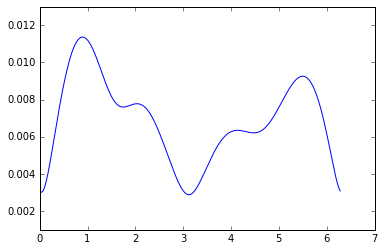

In [50]:
y = np.sqrt(np.abs(Uvars))
plt.plot(angles, y)
plt.ylim(0.001,0.013)

In [49]:
y.mean(), y.max()

(0.0068832179999762152, 0.011362373989345339)